In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

['/home/hieutt/RD-OpenMax_CAN_IDS/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [ ]:
import os
import torch
import numpy as np
import pickle
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.manifold import TSNE
import seaborn as sns
from dataset import CANDatasetEnet as CANDataset
from torchvision import transforms
from torch.utils.data import DataLoader


In [3]:

train_dataset_folder = "../data/set_04/train_01/preprocessed/six_features/TFRecord_w64_s32/2"
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
normalize = transforms.Normalize(mean=mean, std=std)
transform = transforms.Compose([normalize])

# Khởi tạo dataset
train_dataset = CANDataset(root_dir=train_dataset_folder, window_size=32, is_train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)

In [4]:
from tfrecord.torch.dataset import TFRecordDataset
import torch
import numpy as np
from tqdm import tqdm

def load_ood_from_tfrecord(tfrecord_path, max_samples=1000):
    index_path = tfrecord_path + '.index'
    description = {
        "id_seq": "float",
        "data_seq": "float",
        "timestamp": "float",
        "label": "int"
    }

    dataset = TFRecordDataset(tfrecord_path, index_path, description)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

    tensors = []
    for i, data in enumerate(tqdm(dataloader)):
        if i >= max_samples:
            break
        id_seq = data['id_seq'].view(64, 64)
        data_seq = data['data_seq'].view(64, 64)
        timestamp = data['timestamp'].view(64, 64)
        x = torch.stack([id_seq, data_seq, timestamp], dim=0)  # [3, 64, 64]
        tensors.append(x)

    return torch.stack(tensors)  # [N, 3, 64, 64]


In [5]:
X_train_batch, _ = next(iter(train_loader))  # [B, 3, 64, 64]
X_train = X_train_batch[:300].cpu()


In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_tsne(X_train, X_ood, n_samples=300):
    X1 = X_train[:n_samples].reshape(n_samples, -1).cpu().numpy()
    X2 = X_ood[:n_samples].reshape(n_samples, -1).cpu().numpy()
    
    X = np.vstack([X1, X2])
    labels = ['Closed-set'] * n_samples + ['AC-GAN OOD'] * n_samples

    X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

    plt.figure(figsize=(8,6))
    for label in set(labels):
        idx = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label, alpha=0.6)
    plt.legend()
    plt.title("t-SNE: Closed-set vs AC-GAN OOD")
    plt.grid(True)
    plt.show()


0it [00:00, ?it/s]

1000it [00:01, 535.51it/s]


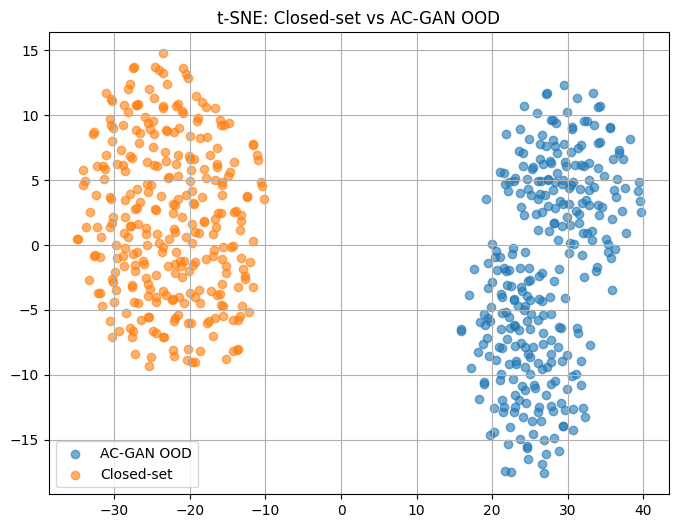

In [8]:
tfrecord_path = '../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/ood/acgan/generated_ood.tfrecord'  # hoặc đường dẫn tương ứng
X_ood = load_ood_from_tfrecord(tfrecord_path)
# /home/hieutt/RD-OpenMax_CAN_IDS/data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/ood/acgan/generated_ood.tfrecord
import torch
X_train_samples = []

# Lấy đúng 300 sample để visualize
for x_batch, _ in train_loader:
    X_train_samples.append(x_batch)
    if sum([x.shape[0] for x in X_train_samples]) >= 300:
        break

X_train = torch.cat(X_train_samples, dim=0)[:300]

visualize_tsne(X_train, X_ood)
